In [4]:
import os
import random

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, ColorJitter, Normalize, Resize

import numpy as np

import segmentation_models_pytorch as smp

from torch import nn
import torch
import torchvision.transforms.functional as TF

import time

import torch.backends.mps
from torch.utils.data import DataLoader

# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/train.py

In [42]:
# Loading data

IMG_TRANSFORM = Compose([
    Resize((256, 256)),  # Resize the image to 256x256
    # ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    ToTensor(),  # Convert the image to a PyTorch tensor
    # Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])  # Normalize
])

MASK_TRANSFORM = Compose([
    Resize((256, 256)),  # Resize the image to 256x256
    ToTensor(),
])

# Transformation that need to be applied to both the image and mask (at the same time)
COMMON_TRANSFORM = Compose([
    RandomHorizontalFlip()
])

# TODO: I wonder if my masks are RGB and not binary greyscale so that is why the model is not learning

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        """
        Custom dataset for segmentation tasks.

        Args:
            img_dir (str): Path to the folder containing images.
            mask_dir (str): Path to the folder containing masks.
            img_transform (callable, optional): Optional transform to be applied to the image.
            mask_transform (callable, optional): Optional transform to be applied to the mask.
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        # List all image and mask files in the directories
        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

        # Check if the number of images and masks match
        assert len(self.img_files) == len(self.mask_files), "Number of images and masks must be the same."

    def binarize(self, image, threshold: int = 127) -> Image:
        return image.point(lambda p: p > threshold and 255)
   
    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Get the file names for the corresponding image and mask
        img_name = os.path.join(self.img_dir, self.img_files[idx])
        mask_name = os.path.join(self.mask_dir, self.mask_files[idx])

        # Open image and mask files
        img = Image.open(img_name)
        mask = Image.open(mask_name)

        mask = mask.convert("L")

        # mask = self.binarize(mask)

        # Apply transformations, if specified
        if self.img_transform:
            img = self.img_transform(img)

        if self.mask_transform:
            mask = self.mask_transform(mask)

            # Normalize the mask to [0, 1] as tensors
            mask = mask / 255.0

        

        return img, mask

Size of dataset: 280


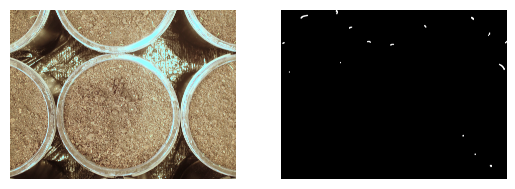

In [43]:
data_raw = SegmentationDataset("../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs", "../datasets/niab/EXP01/Top_Images/Masked_Dataset/masks")

random_index = random.randint(0, len(data_raw) - 1)  # Take an image at random from the training dataset
image = data_raw[random_index]

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.axis('off')

# Plot mask
plt.subplot(1, 2, 2)
plt.imshow(image[1], cmap='gray')
plt.axis('off')

print(f"Size of dataset: {len(data_raw)}")
# print(f"Image shape: {image[1].shape}")

# TODO: Be sure that the segmentation masks are binary and not RGB
# I am pretty sure at the moment that the masks are RGB as they are a jpeg image and not a png image - I need to convert them to greyscale
# print(f"Unique values in mask: {torch.unique(image[1])}")

# If my masks were truly binary, I would expect to see only two colors in the mask image but I am seeing green and yellow

plt.show()

Size of training dataset: 224
Size of validation dataset: 56
Shape of first input entry (post-transformation): torch.Size([3, 256, 256])
Shape of first label entry (post-transformation): torch.Size([1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

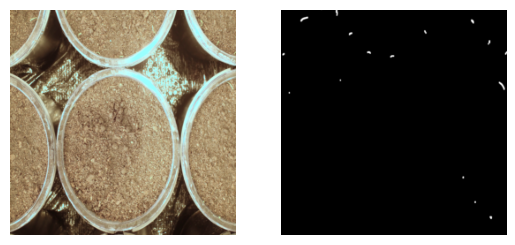

In [55]:
data_processed = SegmentationDataset("../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs", "../datasets/niab/EXP01/Top_Images/Masked_Dataset/masks",
                                           img_transform=IMG_TRANSFORM, mask_transform=MASK_TRANSFORM)

# Split the dataset into training and validation sets
total_size = len(data_processed)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
training_dataset, validation_dataset = random_split(data_processed, [train_size, val_size])

# How much data?
print(f"Size of training dataset: {len(training_dataset)}")
print(f"Size of validation dataset: {len(validation_dataset)}")

# Post-transformation, what does the data look like?
print(f"Shape of first input entry (post-transformation): {data_processed[0][0].shape}")
print(f"Shape of first label entry (post-transformation): {data_processed[0][1].shape}")

# random_index = random.randint(0, len(data_processed) - 1)  # Take an image at random from the training dataset
image = data_processed[random_index]

# Plot data post transformation i.e. what does the model see
plt.subplot(1, 2, 1)
plt.imshow(image[0].permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image[1].permute(1, 2, 0), cmap='gray')
plt.axis('off')


In [59]:
# Parameters
# https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size
# https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu
# It has been observed that with larger batch there is a significant degradation in the quality of the model, as
# measured by its ability to generalize i.e. large batch size is better for training but not for generalization
# (overfitting)
BATCH_SIZE = 2 ** 4
EPOCHS = 5

# Detect device for training and running the model
# Installing CUDA - https://docs.nvidia.com/cuda/cuda-quick-start-guide/
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training/fitting using {device} device")

# Create a data loader to handle loading data in and out of memory in batches

# Create data loaders.
train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Look at the shape of the data coming out of the data loader (batch size, channels, height, width)
for X, y in validation_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get the shape on the first item in the dataset
print(f"Shape of first input entry: {training_dataset[0][0].shape}")

# Create an instance of the model and move it to the device (GPU or CPU)
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).to(device)

def fit(dataloader, model, loss_fn, optimizer, scheduler, device, log_freq=10) -> None:
    """
    Fit the model to the data using the loss function and optimizer
    Taken from the official PyTorch quickstart tutorial (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
    :param dataloader:
    :param model:
    :param loss_fn:
    :param optimizer:
    :param scheduler:
    :param device:
    :param log_freq:
    :return: None
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # move data to device (GPU or CPU), ensure that the data and model are on the same device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # forward pass
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # backward pass (calculate gradients)
        optimizer.step()  # update params
        optimizer.zero_grad()  # reset gradients to zero
        # scheduler.step()  # update learning rate (decay)

        # To avoid too much output, only print every n batches (log_freq), by default every 10 batches
        if batch % log_freq == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# def validate(dataloader, model, loss_fn):
#     """
#     Validate the model on the validation dataset (unseen data), used for hyperparameter tuning
#     Taken from the official PyTorch quickstart tutorial (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
#     :param dataloader:
#     :param model:
#     :param loss_fn:
#     :return:
#     """
#     num_batches = len(dataloader)
#     model.eval()
#     val_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             val_loss += loss_fn(pred, y).item()

#             # % of correctly classified pixels (above a threshold of 0.5 confidence)
#             accuracy = calculate_binary_accuracy(pred, y)
#             correct += accuracy
#     val_loss /= num_batches
#     correct /= num_batches
#     print(f"Validation Error: \n Accuracy: {correct :>0.1f}%, Avg loss: {val_loss:>8f} \n")

# loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4) # high learning rate and allow it to decay
# scheduler = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    fit(train_dataloader, model, loss_fn, optimizer, None, device, log_freq=2)
    # validate(validation_dataloader, model, loss_fn)
print("Done!")

# # Save model in models folder, create if it doesn't exist
# os.makedirs("/content/drive/MyDrive/crop_field_segmentation/models", exist_ok=True)
# torch.save(model.state_dict(), f"/content/drive/MyDrive/crop_field_segmentation/models/model_{time.strftime('%Y%m%d-%H%M%S')}.pth")
# print("Saved PyTorch model state in models folder")


Training/fitting using cuda device
Shape of X: torch.Size([16, 3, 256, 256])
Shape of y: torch.Size([16, 1, 256, 256]) torch.float32
Shape of first input entry: torch.Size([3, 256, 256])
Epoch 1
-------------------------------
loss: 0.999914  [   16/  224]
loss: 0.999757  [   96/  224]
loss: 0.999772  [  176/  224]
Epoch 2
-------------------------------
loss: 0.999816  [   16/  224]
loss: 0.999623  [   96/  224]
loss: 0.999683  [  176/  224]
Epoch 3
-------------------------------
loss: 0.999746  [   16/  224]
loss: 0.999495  [   96/  224]
loss: 0.999571  [  176/  224]
Epoch 4
-------------------------------
loss: 0.999649  [   16/  224]
loss: 0.999314  [   96/  224]
loss: 0.999410  [  176/  224]
Epoch 5
-------------------------------
loss: 0.999509  [   16/  224]
loss: 0.999082  [   96/  224]
loss: 0.999203  [  176/  224]
Done!


Running model using cuda device
torch.Size([1, 3, 256, 256])
Prediction shape: torch.Size([1, 1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

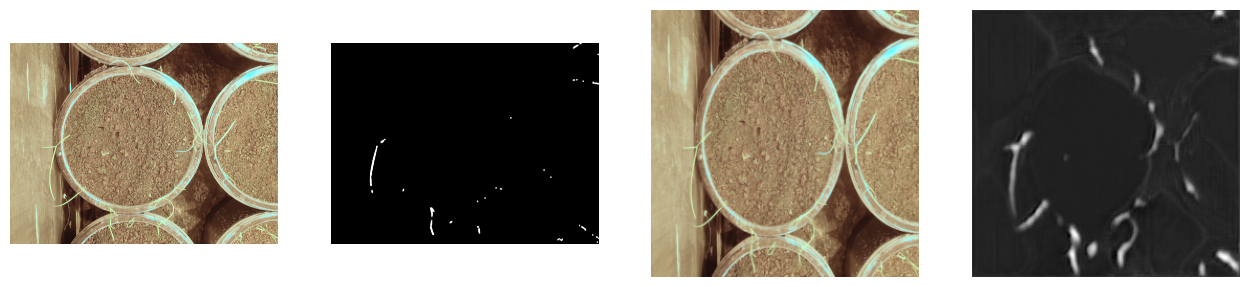

In [60]:
MODEL_PATH = "/home/users/ashine/gws/niab-automated-phenotyping/models_20240421-155051.pth"

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running model using {device} device")

random_index = random.randint(0, len(data_raw) - 1)  # Take an image at random from the training dataset

# Take a random image from the test dataset
raw_img, raw_mask = data_raw[random_index]
processed_img, _ = data_processed[random_index]

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
# model = UNET().to(device)  # 1 class for field segmentation (binary segmentation)
# model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

print(processed_img.unsqueeze(0).shape)

# Make a prediction
pred = model(processed_img.unsqueeze(0).to(device))

print(f"Prediction shape: {pred.shape}")

threshold = 0.4
pred_binary = (pred > threshold).float()

# accuracy = calculate_binary_accuracy(pred, raw_mask)
# accuracy_quantized = calculate_binary_accuracy(pred_binary, raw_mask)

# Plot the image, mask and prediction next to each other
plt.figure(figsize=(20, 10))  # Adjust the width (15) and height (5) as needed

plt.subplot(1, 5, 1)
plt.imshow(raw_img)
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(raw_mask, cmap='gray')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(processed_img.cpu().detach().permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0), cmap='gray')
plt.axis('off')
# plt.subplot(1, 5, 5)
# plt.imshow(pred_binary[0].cpu().detach().permute(1, 2, 0))  # qantized after based on prediction estimates
# plt.axis('off')
